## Particle tracking with MODFLOW 6 PRT

This notebook demonstrates particle tracking with MODFLOW 6 PRT and
MODPATH 7 side-by-side. First an example problem from the MODPATH 7
documentation is solved by equivalent PRT and MP7 models. Next, a
DISV model is created to demonstrate PRT's ability to handle DISV
(unstructured vertex) grids with non-rectangular polygonal cells.

**Note:** anyone who would like to try interactive 3D plots:

```shell
conda install -c conda-forge ipywidgets trame trame-vtk trame-client trame-server trame-vuetify
```

Substitute e.g. `mamba`/`micromamba` if needed.

First import dependencies.

In [1]:
import pathlib as pl
import flopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
import warnings
from flopy.export.vtk import Vtk
from flopy.utils.gridgen import Gridgen
from flopy.utils.gridintersect import GridIntersect
from flopy.discretization import VertexGrid
from flopy.utils.triangle import Triangle as Triangle
from flopy.utils.voronoi import VoronoiGrid
from shapely.geometry import LineString, Point, MultiPoint, Polygon
from matplotlib import colormaps as cm

Suppress warnings.

In [2]:
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", DeprecationWarning)

Make sure GRIDGEN, Triangle, and MODPATH 7 are installed.

In [3]:
flopy.utils.get_modflow(":python", subset="gridgen,triangle,mp7")

auto-selecting option ':python' for 'bindir'
fetched release '18.0' info from MODFLOW-USGS/executables
using previous download 'C:\Users\wbonelli\Downloads\modflow_executables-18.0-win64.zip' (use 'force=True' to re-download)
extracting 3 files to 'C:\Users\wbonelli\AppData\Local\miniconda3\envs\mfandmore2024\Scripts'
gridgen.exe (1.0.02) mp7.exe (7.2.001)    triangle.exe (1.6)
updated flopy metadata file: 'C:\Users\wbonelli\AppData\Local\flopy\get_modflow.json'


Define the base workspace.

In [4]:
example_name = "tracking"
base_ws = pl.Path("temp") / example_name

### MODPATH 7 Example Problem 2

This problem is reproduced from the MODPATH 7 user guide examples
document ([Pollock, 2016](http://dx.doi.org/10.3133/ofr20161086)).

The flow system consists of two aquifers with a low conductivity
confining layer in between. The model grid is roughly square. There is
a quad-refined region around a central well and a river runs along the
grid's eastern boundary.

Particles are released from the four lateral faces of the well and tracked
backwards to recharge points at the water table.


#### Grid refinement

Our first step is to create a quad-refined grid. For this we will use the [GRIDGEN](https://www.usgs.gov/software/gridgen-program-generating-unstructured-finite-volume-grids) program.

The grid will have 3 refinement levels. First we create a "dummy" structured grid discretization to use as a base for refinement.

In [5]:
# Base grid properties
Lx = 10000.0
Ly = 10500.0
nlay = 3
nrow = 21
ncol = 20
delr = Lx / ncol
delc = Ly / nrow
top = 400
botm = [220, 200, 0]

In [6]:
# Create a "dummy" discretization
ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

We are now ready to refine the grid.

In [7]:
# Create gridgen workspace and object
gridgen_ws = base_ws / "gridgen"
gridgen_ws.mkdir(parents=True, exist_ok=True)
gridgen = Gridgen(ms.modelgrid, model_ws=gridgen_ws)

In [8]:
# Define refinement polygons
ref_polys = [
    [[(3500, 4000), (3500, 6500), (6000, 6500), (6000, 4000), (3500, 4000)]],  # outer
    [[(4000, 4500), (4000, 6000), (5500, 6000), (5500, 4500), (4000, 4500)]],  # middle
    [[(4500, 5000), (4500, 5500), (5000, 5500), (5000, 5000), (4500, 5000)]],  # inner
]
ref_paths = []
for i, poly in enumerate(ref_polys):
    gridgen.add_refinement_features([poly], "polygon", i + 1, range(nlay))
    ref_paths.append(gridgen_ws / f"rf{i}")

In [9]:
# Build the refined grid
gridgen.build(verbose=False)
grid_props = gridgen.get_gridprops_vertexgrid()
disv_props = gridgen.get_gridprops_disv()
grid = flopy.discretization.VertexGrid(**grid_props)

In [10]:
# Extract refined grid properties
ncpl = disv_props["ncpl"]
top = disv_props["top"]
botm = disv_props["botm"]
nvert = disv_props["nvert"]
vertices = disv_props["vertices"]
cell2d = disv_props["cell2d"]

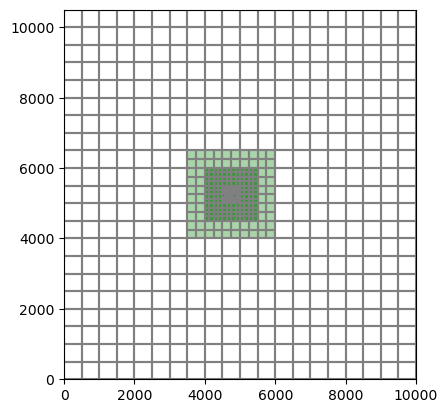

In [11]:
# Plot the grid with refinement levels superimposed.
grid.plot()
for i, path in enumerate(ref_paths):
    flopy.plot.plot_shapefile(path, ax=plt.gca(), facecolor="green", edgecolor="none", alpha=(i + 1) / 3)
plt.show()

#### Groundwater flow model

We are ready to create the GWF model. First, define the model name, workspace, units, and some parameters.

Define the model name and workspace.

In [12]:
gwf_name = f"{example_name}-gwf"
gwf_ws = base_ws / "gwf"
gwf_ws.mkdir(exist_ok=True, parents=True)

Define model units.

In [13]:
length_units = "feet"
time_units = "days"

Define model parameters.

In [14]:
nper = 1  # Number of periods
nlay = 3  # Number of layers (base grid)
nrow = 21  # Number of rows (base grid)
ncol = 20  # Number of columns (base grid)
delr = 500.0  # Column width ($ft$)
delc = 500.0  # Row width ($ft$)
top = 400.0  # Top of the model ($ft$)
botm = [220.0, 200.0, 0.0]  # Layer bottom elevations ($ft$)
porosity = 0.1  # Soil porosity (unitless)
rrch = 0.005  # Recharge rate ($ft/d$)
kh = [50.0, 0.01, 200.0]  # Horizontal hydraulic conductivity ($ft/d$)
kv = [10.0, 0.01, 20.0]  # Vertical hydraulic conductivity ($ft/d$)
wel_q = -150000.0  # Well pumping rate ($ft^3/d$)
riv_h = 320.0  # River stage ($ft$)
riv_z = 317.0  # River bottom ($ft$)
riv_c = 1.0e5  # River conductance ($ft^2/d$)

Define the time discretization.

In [15]:
nstp = 1
perlen = 1000.0
tsmult = 1.0
tdis_rc = [(perlen, nstp, tsmult)]

Now we can begin to construct the GWF model.

In [16]:
sim = flopy.mf6.MFSimulation(
    sim_name=gwf_name, exe_name="mf6", version="mf6", sim_ws=gwf_ws
)
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", perioddata=tdis_rc, nper=len(tdis_rc)
)
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=gwf_name, model_nam_file="{}.nam".format(gwf_name)
)
gwf.name_file.save_flows = True
disv = flopy.mf6.ModflowGwfdisv(
    gwf,
    length_units=length_units,
    **disv_props,  # from grid refinement above
)
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=riv_h)  # initial heads at river stage
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    xt3doptions=[("xt3d")],
    icelltype=[1, 0, 0],
    k=kh,
    k33=kv,
    save_saturation=True,
    save_specific_discharge=True,
)

Define the model's boundary conditions. These include a well, a river, and recharge. Instead of manually setting cell IDs for the well and river, we will determine cell IDs by defining boundary coordinates and intersecting them with the grid.

In [17]:
# Create intersection object
ix = GridIntersect(gwf.modelgrid, method="vertex", rtree=True)

In [18]:
# Create the well package
wel_coords = [(4718.45, 5281.25)]
welcells = ix.intersects(MultiPoint(wel_coords))
welcells = [icpl for (icpl,) in welcells]
welspd = [[(2, icpl), -150000.0] for icpl in welcells]
wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True, stress_period_data=welspd)

In [19]:
# Create the river package
riv_iface = 6
riv_iflowface = -1
riverline = [(Lx - 1.0, Ly), (Lx - 1.0, 0.0)]
rivcells = ix.intersects(LineString(riverline))
rivcells = [icpl for (icpl,) in rivcells]
rivspd = [
    [(0, icpl), riv_h, riv_c, riv_z, riv_iface, riv_iflowface] for icpl in rivcells
]
riv = flopy.mf6.ModflowGwfriv(
    gwf, stress_period_data=rivspd, auxiliary=[("iface", "iflowface")]
)

In [20]:
# Create the recharge package
rch_iface = 6
rch_iflowface = -1
rch = flopy.mf6.ModflowGwfrcha(
    gwf,
    recharge=rrch,
    auxiliary=["iface", "iflowface"],
    aux=[rch_iface, rch_iflowface],
)

Finally we can create the output control and solver packages.

In [21]:
# Create the output control package
headfile_name = "{}.hds".format(gwf_name)
budgetfile_name = "{}.cbb".format(gwf_name)
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    pname="oc",
    budget_filerecord=[budgetfile_name],
    head_filerecord=[headfile_name],
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

In [22]:
# Create the iterative model solution (IMS) package and register it with the model.
ims = flopy.mf6.ModflowIms(
    sim,
    pname="ims",
    outer_dvclose=1.0e-5,
    outer_maximum=100,
    under_relaxation="NONE",
    inner_maximum=100,
    inner_dvclose=1.0e-6,
    rcloserecord=0.1,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=0.99,
)
sim.register_ims_package(ims, [gwf.name])

We can now write and run the GWF simulation.

In [23]:
sim.write_simulation(silent=False)
sim.run_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model tracking-gwf...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...
FloPy is using the following executable to run the model: ..\..\..\..\..\..\..\AppData\Local\miniconda3\envs\mfandmore2024\Scripts\mf6.exe
                               MODFLOW 6 EXTENDED
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled May 23 2024 18:08:14 with Intel(R) Fortran Intel(R) 64
  Compiler Classic for

(True, [])

Load head output from the flow model.

In [24]:
hds = gwf.output.head().get_data()

Plot the heads.

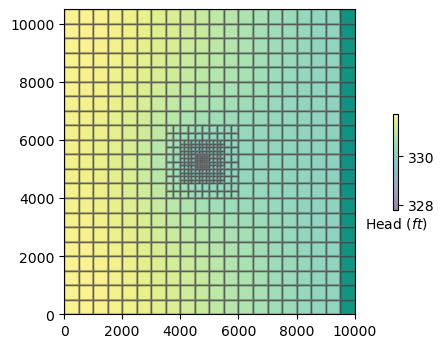

In [25]:
fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=2)
mm.plot_grid(alpha=0.25)
mm.plot_bc("WEL", plotAll=True, color="red")
mm.plot_bc("RIV", plotAll=True, color="teal")
pc = mm.plot_array(hds[:, 0, :], edgecolor="black", alpha=0.5)
cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
cb.ax.set_xlabel(r"Head ($ft$)")
plt.show()

#### MODPATH 7 Model

Next, we can create a MODPATH 7 particle tracking model using the flow model we just created. The first step is to define the particle release configuration. We distribute particles evenly around the 4 lateral faces of the well.

In [26]:
face_data = flopy.modpath.FaceDataType(
    rowdivisions5=0,
    columndivisions5=0,
    rowdivisions6=0,
    columndivisions6=0
)
particle_data = flopy.modpath.NodeParticleData(
    nodes=ncpl * 2 + welcells[0],
    subdivisiondata=face_data
)
particle_group = flopy.modpath.ParticleGroupNodeTemplate(
    particlegroupname="PG",
    particledata=particle_data,
    filename="pg.sloc",
)

Now define the model name and workspace.

In [27]:
mp7_name = f"{example_name}-mp7"
mp7_ws = base_ws / "mp7"
mp7_ws.mkdir(exist_ok=True, parents=True)

Build the MP7 model.

In [28]:
mp7_sim = flopy.modpath.Modpath7(
    modelname=mp7_name,
    flowmodel=gwf,
    exe_name="mp7",
    model_ws=mp7_ws,
    budgetfilename=budgetfile_name,
    headfilename=headfile_name,
)

In [29]:
mp7_bas = flopy.modpath.Modpath7Bas(mp7_sim, porosity=porosity)

In [30]:
mp7 = flopy.modpath.Modpath7Sim(
    mp7_sim,
    simulationtype="combined",
    trackingdirection="backward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    referencetime=0.0,
    stoptimeoption="extend",
    timepointdata=[500, 1000.0],
    particlegroups=[particle_group],
)

Write and run the MP7 model.

In [31]:
mp7_sim.write_input()
mp7_sim.run_model(silent=False)

FloPy is using the following executable to run the model: ..\..\..\..\..\..\..\AppData\Local\miniconda3\envs\mfandmore2024\Scripts\mp7.exe

MODPATH Version 7.2.001   
Program compiled Feb 19 2024 14:23:08 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
        36 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         0 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                           

(True, [])

Load pathlines from the MP7 pathline output file.

In [32]:
mp7_pathline_file = flopy.utils.PathlineFile(mp7_ws / f"{mp7_name}.mppth")
mp7_pathlines = pd.DataFrame(
    mp7_pathline_file.get_destination_pathline_data(
        list(range(gwf.modelgrid.nnodes)), to_recarray=True
    )
)

Plot MP7 pathlines in plan view.

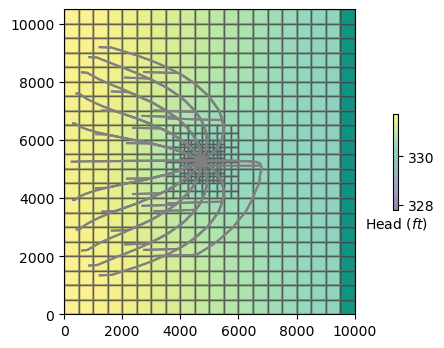

In [33]:
fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=2)
mm.plot_grid(alpha=0.25)
mm.plot_bc("WEL", plotAll=True, color="red")
mm.plot_bc("RIV", plotAll=True, color="teal")
pc = mm.plot_array(hds[:, 0, :], edgecolor="black", alpha=0.5)
cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
cb.ax.set_xlabel(r"Head ($ft$)")
mm.plot_pathline(mp7_pathlines, layer="all")
plt.show()

Next we can create a 3D pathline plot. The first step is to export results to VTK and convert them to PyVista meshes.

In [34]:
vert_exag = 10
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=False)
vtk.add_model(gwf)
vtk.add_pathline_points(mp7_pathlines.to_records(index=False))
gwf_mesh, mp7_mesh = vtk.to_pyvista()

We will add a few more meshes to show the confining bed and boundaries.

In [35]:
riv_mesh = pv.Box(
    bounds=[
        gwf.modelgrid.extent[1] - delc,
        gwf.modelgrid.extent[1],
        gwf.modelgrid.extent[2],
        gwf.modelgrid.extent[3],
        botm[0] * vert_exag,
        hds[(0, 0, ncol - 1)] * vert_exag,
    ]
)
well_points = gwf.modelgrid.verts[gwf.modelgrid.iverts[welcells[0]]]
well_xs, well_ys = list(zip(*well_points))
wel_mesh = pv.Box(bounds=[
    min(well_xs),
    max(well_xs),
    min(well_ys),
    max(well_ys),
    botm[-1] * vert_exag,
    botm[-2] * vert_exag])
bed_mesh = pv.Box(
    bounds=[
        gwf.modelgrid.extent[0],
        gwf.modelgrid.extent[1],
        gwf.modelgrid.extent[2],
        gwf.modelgrid.extent[3],
        botm[1] * vert_exag,
        botm[0] * vert_exag,
    ]
)

Create the 3D plot.

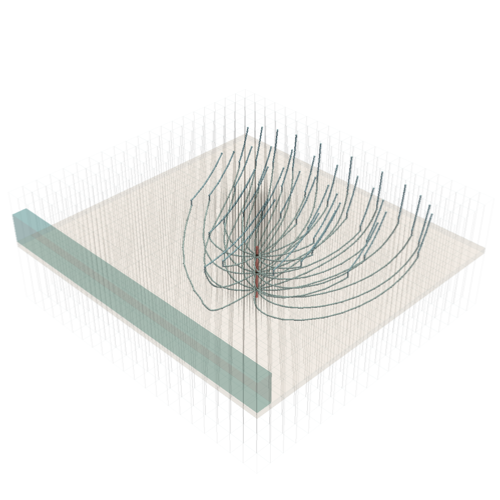

In [36]:
pv.set_plot_theme("document")
pv.set_jupyter_backend('static')
axes = pv.Axes(show_actor=False, actor_scale=2.0, line_width=5)
p = pv.Plotter(
    window_size=[500, 500],
    notebook=True,
)
p.enable_anti_aliasing()
p.add_mesh(gwf_mesh, opacity=0.025, style="wireframe")
p.add_mesh(
    mp7_mesh,
    point_size=4,
    line_width=3,
    render_points_as_spheres=True,
    render_lines_as_tubes=True,
    smooth_shading=True,
)
p.add_mesh(riv_mesh, color="teal", opacity=0.2)
p.add_mesh(wel_mesh, color="red", opacity=0.3)
p.add_mesh(bed_mesh, color="tan", opacity=0.1)
p.show()

#### PRT Model

We can now create a PRT model equivalent to the MP7 model. First we define the model name and workspace.

In [37]:
prt_name = f"{example_name}-prt"
prt_ws = base_ws / "prt"
prt_ws.mkdir(exist_ok=True, parents=True)

Create the simulation and time discretization.

In [38]:
sim = flopy.mf6.MFSimulation(
    sim_name=prt_name, exe_name="mf6", version="mf6", sim_ws=prt_ws
)

In [39]:
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", perioddata=tdis_rc, nper=len(tdis_rc)
)

Create the PRT model and grid discretization.

In [40]:
# Create PRT model
prt = flopy.mf6.ModflowPrt(
    sim, modelname=prt_name, model_nam_file="{}.nam".format(prt_name)
)

In [41]:
# Create grid discretization
disv = flopy.mf6.ModflowGwfdisv(
    prt,
    length_units=length_units,
    **disv_props,
)

Create the PRT model input package, which is used to configure model-scoped settings (e.g. porosity).

In [42]:
mip = flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

Now we create the particle release configuration for PRT. Unlike MODPATH 7,
PRT does not provide "templates" to arrange particles on cell faces or within
cells &mdash; rather particle release points must be configured explicitly in
pre-processing. Evenly spaced distributions of particles can be easily created
with `numpy.meshgrid()`.

To streamline (:wink:) the migration of MODPATH 7 models to MODFLOW 6 PRT,
FloPy provides utilities to convert MP7 particle release configurations to
global coordinates (MP7 expects cell-local coordinates) or directly to the
format expected by the PRT particle release point (PRP) package. Below we
use the `NodeParticleData.to_prp()` method to achieve the latter. Note that
this method returns an iterator rather than a materialized list.

In [43]:
releasepts = list(particle_data.to_prp(grid))
prp = flopy.mf6.ModflowPrtprp(
    prt,
    pname="prp",
    filename=f"{prt_name}.prp",
    nreleasepts=len(releasepts),
    packagedata=releasepts,
    perioddata={0: ["FIRST"]},
    exit_solve_tolerance=1e-5,
)

We can now create the MODFLOW 6 PRT output control package. This package is
used to configure PRT output files. PRT can write pathline output to binary
or CSV files. PRT can also create a cell budget output file, which contains
intercell mass flows.

The output control package is also used to configure **tracking events**.
This is another point of departure between PRT and MODPATH. MP7 supports
four distinct simulation modes:
  - endpoint
  - pathline
  - timeseries
  - combined pathline and timeseries

The tracking algorithm used by MP7 is functionally identical in all four modes;
the mode controls only how output is reported. PRT, on the other hand, has just
a single mode, and output is configured by selecting tracking events:
  - release
  - (sub)cell exit
  - timestep end
  - termination
  - weak sink cell exit
  - user-specified time

For example, to configure a PRT model equivalently to an MP7 endpoint simulation,
one would select release and termination events only. For a timeseries simulation,
one would select and provide user-specified times. By default, PRT enables all
tracking events. Below we use this default configuration.


In [44]:
# Create the output control package
budgetfile_prt_name = "{}.bud".format(prt_name)
trackfile_name = "{}.trk".format(prt_name)
trackcsvfile_name = "{}.trk.csv".format(prt_name)
budget_record = [budgetfile_prt_name]
track_record = [trackfile_name]
trackcsv_record = [trackcsvfile_name]
tracktimes = list(range(0, 500001, 1000))
oc = flopy.mf6.ModflowPrtoc(
    prt,
    pname="oc",
    budget_filerecord=budget_record,
    track_filerecord=track_record,
    trackcsv_filerecord=trackcsv_record,
    track_timesrecord=tracktimes,
    saverecord=[("BUDGET", "ALL")],
)

Next we configure PRT to consume the output of the GWF model we ran
earlier via the flow model interface (FMI) package. Since we want to
track particles backwards from a known capture point, we first reverse
the GWF model's head/budget files. FloPy `HeadFile` and `CellBudgetFile`
classes provide utilities to do this.

In [45]:
head_file = flopy.utils.HeadFile(gwf_ws / headfile_name, tdis=sim.tdis)
budget_file = flopy.utils.CellBudgetFile(gwf_ws / budgetfile_name, precision="double", tdis=sim.tdis)

headfile_bkwd_name = f"{headfile_name}_bkwd"
budgetfile_bkwd_name = f"{budgetfile_name}_bkwd"

head_file.reverse(prt_ws / headfile_bkwd_name)
budget_file.reverse(prt_ws / budgetfile_bkwd_name)

fmi = flopy.mf6.ModflowPrtfmi(prt, packagedata=[
    ("GWFHEAD", headfile_bkwd_name),
    ("GWFBUDGET", budgetfile_bkwd_name),
])

Finally we create an explicit model solution for PRT. The PRT model is
unlike other MODFLOW 6 model types in that it includes its own solution
procedures for particle tracking. PRT does not use the iterative
matrix solvers used by other model types.

In [46]:
ems = flopy.mf6.ModflowEms(
    sim,
    pname="ems",
    filename="{}.ems".format(prt_name),
)
sim.register_solution_package(ems, [prt.name])

We are now ready to write and run the PRT model.

In [47]:
sim.write_simulation(silent=False)
sim.run_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model tracking-prt...
    writing model name file...
    writing package disv...
    writing package mip...
    writing package prp...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ..\..\..\..\..\..\..\AppData\Local\miniconda3\envs\mfandmore2024\Scripts\mf6.exe
                               MODFLOW 6 EXTENDED
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled May 23 2024 18:08:14 with Intel(R) Fortran Intel(R) 64
  Compiler Classic for applications running on Intel(R) 64, Version 2021.11.1
                             Build 20231117_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserve

(False, [])

We can now load PRT pathlines from the CSV output file.

In [48]:
prt_pathlines = pd.read_csv(prt_ws / trackcsvfile_name)

Create a 3D pathline plot comparing MP7 and PRT pathlines. They should be equivalent to several decimal places, so we expect to see just one set of pathlines despite plotting both.

In [49]:
vert_exag = 10
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=False)
vtk.add_model(gwf)
vtk.add_pathline_points(prt_pathlines.to_records(index=False))
gwf_mesh, prt_mesh = vtk.to_pyvista()

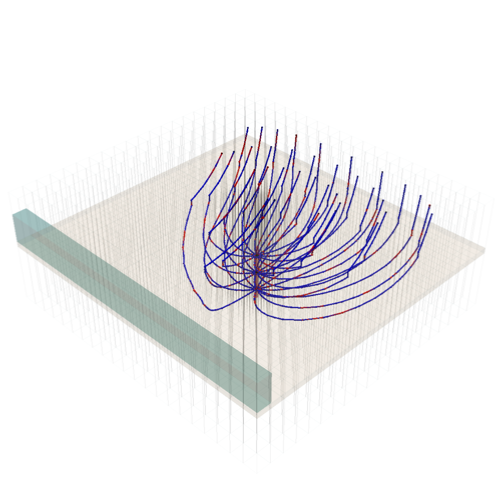

In [50]:
axes = pv.Axes(show_actor=False, actor_scale=2.0, line_width=5)
# pv.set_jupyter_backend("trame")
p = pv.Plotter(
    window_size=[500, 500],
    notebook=True,
)
p.enable_anti_aliasing()
p.add_mesh(gwf_mesh, opacity=0.025, style="wireframe")
p.add_mesh(
    mp7_mesh,
    point_size=4,
    line_width=3,
    render_points_as_spheres=True,
    render_lines_as_tubes=True,
    smooth_shading=True,
    color="red"
)
p.add_mesh(
    prt_mesh,
    point_size=4,
    line_width=3,
    render_points_as_spheres=True,
    render_lines_as_tubes=True,
    smooth_shading=True,
    color="blue"
)
p.add_mesh(riv_mesh, color="teal", opacity=0.2)
p.add_mesh(wel_mesh, color="red", opacity=0.3)
p.add_mesh(bed_mesh, color="tan", opacity=0.1)
p.show()

*Oh no!* Why are they different and how can we remedy it?

### Voronoi example

Now that we've demonstrated parity between MODPATH 7 and MODFLOW 6 PRT, we will
create an example model showcasing PRT's ability to solve unstructured vertex
grids with non-rectangular cells. This is a synthetic flow system modeled after
a public park with a stream and a well in a hilly landscape. The model uses a
Voronoi grid with several refined regions. The flow system is steady-state.
Particles are released in a square region in the southwest corner of the grid.

Define model units.

In [51]:
length_units = "feet"
time_units = "years"

Define model parameters.

In [52]:
nper = 1  # Number of periods
nlay = 3  # Number of layers
delr = 25.0  # Column width ($ft$)
delc = 25.0  # Row width ($ft$)
top = 990  # Model top elevation ($ft$)
botm = [950.0, 940.0, 800.0]  # Layer bottom elevations ($ft$)
kh = [50.0, 10.0, 100.0]  # Horizontal hydraulic conductivity ($ft/d$)
kv = [10.0, 5.0, 20.0]  # Vertical hydraulic conductivity ($ft/d$)
rchv = 0.005  # Recharge rate ($ft/d$)
str_h = 980.0  # Stream stage ($ft$)
str_z = 960.0  # Stream bottom ($ft$)
str_c = 1.0e5  # Stream conductance ($ft^2/d$)
riv_h = 980.0  # River stage ($ft$)
riv_z = 960.0  # River bottom ($ft$)
riv_c = 1.0e5  # River conductance ($ft^2/d$)
porosity = 0.1  # Soil porosity (unitless)

#### Grid creation and refinement

We will now create a Voronoi grid with several refinement features.

Define the model domain. The model domain is rectangular, but grid cells will generally not be rectangular (or only incidentally if they are).

In [53]:
domain = [(0, 0), (925, 0), (925, 700), (0, 700)]

Define refinement features: hills in the northwest and southwest and a stream running diagonally along the east side of the grid.

In [54]:
nw_hill_contours = [
    [(70, 690), (30, 530), (210, 530), (270, 490)],
]
sw_hill_contours = [
    [(10, 110), (70, 110), (70, 10)],
    [(10, 150), (90, 190), (130, 190), (190, 170), (170, 110), (150, 10)],
    [(10, 190), (110, 230), (170, 230), (210, 210), (230, 110), (210, 10)],
    [(10, 230), (50, 250), (110, 270), (230, 230), (270, 190), (270, 130), (250, 10)],
    [(10, 270), (110, 290), (250, 270), (290, 250), (310, 30)],
]
river_line = [list(zip(range(590, 891, 10), range(10, 651, 19)))]
features = sw_hill_contours + nw_hill_contours + river_line

Create a `Triangle` workspace and object, then register the refinement features.

In [55]:
# Create triangle workspace and object
triangle_ws = base_ws / "triangle"
triangle_ws.mkdir(parents=True, exist_ok=True)
tri = Triangle(angle=30, model_ws=triangle_ws)
tri.add_polygon(domain)  # active domain must be created first
for poly in features:
    tri.add_polygon(poly)

Build and plot the triangle grid with refinement features.

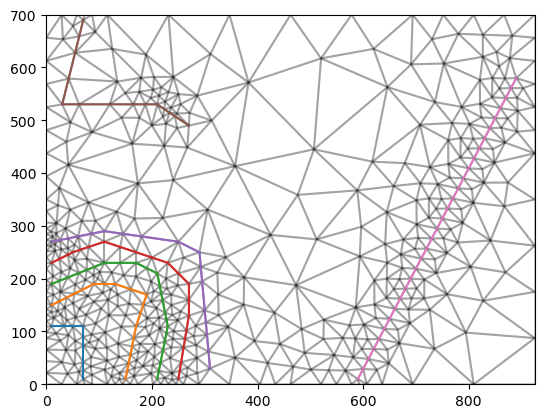

In [56]:
tri.build(verbose=False)
tri.plot(alpha=0.2)
ax = plt.gca()
for feature in features:
    xs, ys = list(zip(*feature))
    ax.plot(xs, ys)
plt.show()

Convert the triangular grid to a Voronoi DISV grid and plot it again.

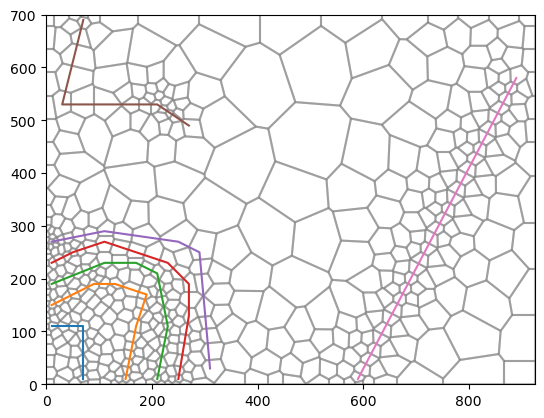

In [57]:
vor = VoronoiGrid(tri)
gridprops = vor.get_gridprops_vertexgrid()
disvprops = vor.get_disv_gridprops()
voronoi_grid = VertexGrid(**gridprops, nlay=1)
voronoi_grid.plot(alpha=0.5)
ax = plt.gca()
for feature in features:
    xs, ys = list(zip(*feature))
    ax.plot(xs, ys)
plt.show()

#### GWF model

We can now construct a flow model.

Begin by preparing the model's top elevation. This is a hilly landscape. Define a few more contours in the southeast corner of the model in order to intersect them with the grid and set the top elevation in the appropriate cells.

In [58]:
# Create southeast hill contours
se_hill_contours = [
    [
        (650, 10),
        (890, 510),
    ],
    [
        (710, 10),
        (890, 450),
    ],
    [
        (790, 10),
        (890, 390),
    ],
]

# Create grid intersection helper
gi = GridIntersect(voronoi_grid, method="vertex")

# Initialize array of top elevations
topa = np.ones((voronoi_grid.ncpl,)) * top

# Set top elevations on southwest hill, starting from the lowest/broadest contour and proceeding inward.
# We will reuse these cell IDs below to set initial heads.
sw_hc3_cells = gi.intersect(Polygon(sw_hill_contours[3] + [(0, 0)])).cellids.astype(int)
sw_hc2_cells = gi.intersect(Polygon(sw_hill_contours[2] + [(0, 0)])).cellids.astype(int)
sw_hc1_cells = gi.intersect(Polygon(sw_hill_contours[1] + [(0, 0)])).cellids.astype(int)
sw_hc0_cells = gi.intersect(Polygon(sw_hill_contours[0] + [(0, 0)])).cellids.astype(int)
topa[sw_hc3_cells] = 1010
topa[sw_hc2_cells] = 1030
topa[sw_hc1_cells] = 1050
topa[sw_hc0_cells] = 1070

# Set top elevations on northwest hill
topa[gi.intersect(LineString(nw_hill_contours[0])).cellids.astype(int)] = 1010

# Set top elevations on southeast hill
topa[gi.intersect(LineString(se_hill_contours[0])).cellids.astype(int)] = 1000
topa[gi.intersect(LineString(se_hill_contours[1])).cellids.astype(int)] = 1010
topa[gi.intersect(LineString(se_hill_contours[2])).cellids.astype(int)] = 1020

Next we can define the model's boundary conditions. As mentioned above, these include a well in the northwest quadrant and a stream in the eastern region.

In [59]:
# Define the well cell ID and pumping rate as expected by the WEL package.
wells = [
    # layer, node, discharge
    (0, 237, -705000),
]

# Define the stream cell IDs and other information as expected by the RIV package.
riv_iface = 6
riv_iflowface = -1
riv_cells = [(0, 120)] + [(0, j) for j in range(35, 66)] + [(0, 124)]
river = [[(k, j), riv_h, riv_c, riv_z, riv_iface, riv_iflowface] for k, j in riv_cells]

# Determine node numbers for the well and stream cells.
nodes = {"well": [], "stream": []}
for k, j, _ in wells:
    nn = k * voronoi_grid.ncpl + j
    nodes["well"].append(nn)
for rivspec in river:
    k, j = rivspec[0]
    nn = k * voronoi_grid.ncpl + j
    nodes["stream"].append(nn)

Next, define zones which will allow us to determine where particles are captured (well or stream). Zone number 1 is the default. Assign the well zone number 2 and the stream zone number 3.

In [60]:
izone = []

# layer 1
l1 = np.ones((voronoi_grid.ncpl,), dtype=np.int32)
l1[[nodes["well"]]] = 2  # well
l1[[nodes["stream"]]] = 3  # stream
izone.append(l1)

# layers 2-3
izone.append(1)
izone.append(1)

We are almost ready to build the simulation. First define the simulation name and workspace.

In [61]:
sim_name = f"{example_name}-vor"
sim_ws = base_ws / "vor"
sim_ws.mkdir(exist_ok=True, parents=True)

Next, define particle release points. As mentioned above, we can use `np.meshgrid` to create an evenly spaced distribution of particles over a square 25ft to a side. We then intersect these points with the model grid to determine cell IDs and construct a list of package data as expected by the particle release point (PRP) package. Note that PRT's PRP package requires both global coordinates and cell IDs, and for these to correspond. PRT conducts a fuzzy check to make sure that particle release points are in the specified cell.

In [62]:
release_points = np.transpose(
    np.array(np.meshgrid(range(25, 50), range(25, 50))).reshape(2, -1)
)
prp_data = [
    [i, (0, gi.intersect(Point(p))[0].cellids), p[0], p[1], 1020.0] for i, p in enumerate(release_points)
]
prp_data

[[0, (0, 268), 25, 25, 1020.0],
 [1, (0, 268), 26, 25, 1020.0],
 [2, (0, 268), 27, 25, 1020.0],
 [3, (0, 268), 28, 25, 1020.0],
 [4, (0, 268), 29, 25, 1020.0],
 [5, (0, 268), 30, 25, 1020.0],
 [6, (0, 268), 31, 25, 1020.0],
 [7, (0, 268), 32, 25, 1020.0],
 [8, (0, 268), 33, 25, 1020.0],
 [9, (0, 268), 34, 25, 1020.0],
 [10, (0, 268), 35, 25, 1020.0],
 [11, (0, 268), 36, 25, 1020.0],
 [12, (0, 268), 37, 25, 1020.0],
 [13, (0, 268), 38, 25, 1020.0],
 [14, (0, 268), 39, 25, 1020.0],
 [15, (0, 268), 40, 25, 1020.0],
 [16, (0, 268), 41, 25, 1020.0],
 [17, (0, 268), 42, 25, 1020.0],
 [18, (0, 268), 43, 25, 1020.0],
 [19, (0, 268), 44, 25, 1020.0],
 [20, (0, 268), 45, 25, 1020.0],
 [21, (0, 268), 46, 25, 1020.0],
 [22, (0, 268), 47, 25, 1020.0],
 [23, (0, 268), 48, 25, 1020.0],
 [24, (0, 268), 49, 25, 1020.0],
 [25, (0, 268), 25, 26, 1020.0],
 [26, (0, 268), 26, 26, 1020.0],
 [27, (0, 268), 27, 26, 1020.0],
 [28, (0, 268), 28, 26, 1020.0],
 [29, (0, 268), 29, 26, 1020.0],
 [30, (0, 268), 30, 

Now we can build the simulation. In the previous MP7 example, PRT ran as a post-processor. In this example, GWF and PRT will run in the same simulation.

In [63]:
sim = flopy.mf6.MFSimulation(
    sim_name=sim_name, exe_name="mf6", version="mf6", sim_ws=sim_ws
)
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim,
    pname="tdis",
    time_units=time_units,
    nper=len(tdis_rc),  # this example uses the same time discretization as the previous example
    perioddata=tdis_rc,
)
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=gwf_name, save_flows=True
)
ims = flopy.mf6.modflow.mfims.ModflowIms(
    sim,
    pname="ims",
    complexity="SIMPLE",
)
sim.register_solution_package(ims, [gwf.name])
dis = flopy.mf6.modflow.mfgwfdisv.ModflowGwfdisv(
    gwf, nlay=3, top=topa, botm=botm, **disvprops
)
strt = np.ones((voronoi_grid.ncpl,)) * 995
strt[sw_hc3_cells] = topa[sw_hc3_cells] + (
    topa[sw_hc3_cells] - strt[sw_hc3_cells] / 2
)
strt[sw_hc2_cells] = topa[sw_hc2_cells] + (
    topa[sw_hc2_cells] - strt[sw_hc2_cells] / 2
)
strt[sw_hc1_cells] = topa[sw_hc1_cells] + (
    topa[sw_hc1_cells] - strt[sw_hc1_cells] / 2
)
strt[sw_hc0_cells] = topa[sw_hc0_cells] + (
    topa[sw_hc0_cells] - strt[sw_hc0_cells] / 2
)
strt = np.stack([strt, strt, strt])
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=strt)
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf,
    pname="npf",
    k=kh,
    k33=kv,
    save_flows=True,
    save_specific_discharge=True,
    save_saturation=True,
)
cells_left = gi.intersect(LineString([(0, 0), (0, 700)]))["cellids"]
cells_right = gi.intersect(LineString([(924, 0), (924, 700)]))["cellids"]
chdlist = []
for i, ic in enumerate(cells_left):
    chdlist.append([(0, ic), 1010.0 + i])
for i, ic in enumerate(cells_right):
    chdlist.append([(0, ic), 980.0 + i])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdlist)
rch = flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(gwf, recharge=rchv)
sto = flopy.mf6.modflow.mfgwfsto.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=1,
    ss=0.0001,
    sy=0.1,
    steady_state={0: True},
)
wel = flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
    gwf,
    maxbound=1,
    stress_period_data={0: wells},
)
riv = flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
    gwf, auxiliary=["iface", "iflowface"], stress_period_data={0: river}
)
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    head_filerecord=[headfile_name],
    budget_filerecord=[budgetfile_name],
)
prt = flopy.mf6.ModflowPrt(
    sim, modelname=prt_name, model_nam_file="{}.nam".format(prt_name)
)
dis = flopy.mf6.modflow.mfgwfdisv.ModflowGwfdisv(
    prt, nlay=3, top=topa, botm=botm, **disvprops
)
mip = flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity, izone=izone)
prp = flopy.mf6.ModflowPrtprp(
    prt,
    pname="prp1",
    filename="{}_1.prp".format(prt_name),
    nreleasepts=len(prp_data),
    packagedata=prp_data,
    exit_solve_tolerance=1e-5,
)
tracktimes = list(range(0, 200, 2))
oc = flopy.mf6.ModflowPrtoc(
    prt,
    pname="oc",
    budget_filerecord=[budgetfile_prt_name],
    trackcsv_filerecord=[trackcsvfile_name],
    track_timesrecord=tracktimes,
    saverecord=[("BUDGET", "ALL")],
)
exg = flopy.mf6.ModflowGwfprt(
    sim,
    exgtype="GWF6-PRT6",
    exgmnamea=gwf_name,
    exgmnameb=prt_name,
    filename=f"{gwf_name}.gwfprt",
)
ems = flopy.mf6.ModflowEms(
    sim,
    pname="ems",
    filename=f"{prt_name}.ems",
)
sim.register_solution_package(ems, [prt.name])

We can now write and run the model.

In [64]:
sim.write_simulation(silent=False)
sim.run_simulation(silent=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing solution package ems...
  writing package tracking-gwf.gwfprt...
  writing model tracking-gwf...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 46 based on size of stress_period_data
    writing package rcha_0...
    writing package sto...
    writing package wel_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 33 based on size of stress_period_data
    writing package oc...
  writing model tracking-prt...
    writing model name file...
    writing package disv...
    writing package mip...
    writing package prp1...
    writing package oc...


(False, [])

Load the GWF model's head and budget output using the `.output.head()` and `.output.budget()` shortcuts for the `HeadFile` and `CellBudgetFile` classes, respectively, then get specific discharge from the cell-by-cell budget.

In [65]:
hds = gwf.output.head().get_data()
spdis = gwf.output.budget().get_data(text="DATA-SPDIS")[0]
qx, qy, _ = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

Load pathlines from the CSV output file, with a bit of post-processing to make it easier to colorcode pathlines by capture zone below.

In [66]:
prt_pathlines = pd.read_csv(sim_ws / trackcsvfile_name)

# index temporarily by composite key fields
prt_pathlines.set_index(["irpt", "trelease"], drop=False, inplace=True)

# determine which particles ended up in which capture zone
prt_pathlines["destzone"] = prt_pathlines[prt_pathlines.istatus > 1].izone
prt_pathlines["dest"] = prt_pathlines.apply(
    lambda row: (
        "well" if row.destzone == 2 else "stream" if row.destzone == 3 else pd.NA
    ),
    axis=1,
)

# reset index
prt_pathlines.reset_index(drop=True, inplace=True)

Filter (sub)cell exit events out of the pathline data, leaving us with a timeseries (plus release and termination points).

In [67]:
prt_pathlines = prt_pathlines[prt_pathlines.ireason != 1]

Plot heads and pathlines in plan view, coloring path points by travel time.

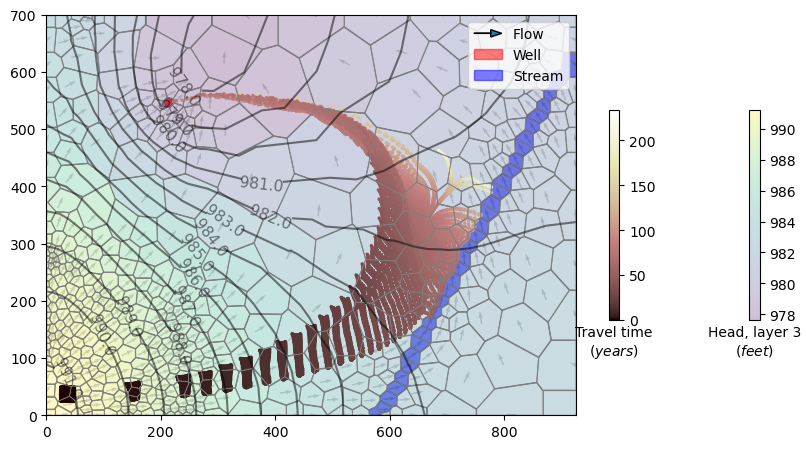

In [68]:
fig, ax = plt.subplots(figsize=(9, 9))
fig.tight_layout()
ax.set_aspect("equal")
ilay = 2  # plot heads for the bottom layer
mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
mm.plot_grid(lw=0.5)
mm.plot_bc("WEL", plotAll=True, color="red", alpha=0.75)
mm.plot_bc("RIV", plotAll=True, color="blue", alpha=0.5)

# plot head array and contours
pc = mm.plot_array(hds, edgecolor="black", alpha=0.25, cmap="viridis")
cb = plt.colorbar(pc, shrink=0.25)
cb.ax.set_xlabel("Head, layer 3\n" + r"($feet$)")
cint = 1
hmin = hds[ilay].min()
hmax = hds[ilay].max()
levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
cs = mm.contour_array(hds, colors="black", levels=levels, alpha=0.5)
plt.clabel(cs, fmt="%.1f", colors="black", fontsize=11)

# plot specific discharge
mm.plot_vector(qx, qy, normalize=True, alpha=0.15)

from matplotlib.legend_handler import HandlerPatch
from matplotlib.patches import FancyArrow

def make_legend_arrow(
    legend, orig_handle, xdescent, ydescent, width, height, fontsize
):
    return FancyArrow(
        0,
        0.5 * height,
        width,
        0,
        length_includes_head=True,
        head_width=0.75 * height,
    )

# create legend
arrow = plt.arrow(0, 0, 0.5, 0.6, label="Flow")
ax.legend(
    handles=[
        arrow,
        mpl.patches.Patch(color="red", label="Well", alpha=0.5),
        mpl.patches.Patch(color="blue", label="Stream", alpha=0.5),
    ],
    loc="upper right",
    handler_map={FancyArrow: HandlerPatch(patch_func=make_legend_arrow)},
)

pts = ax.scatter(prt_pathlines["x"], prt_pathlines["y"], s=2, c=prt_pathlines["t"], cmap=cm["pink"])
cb2 = plt.colorbar(pts, shrink=0.25)
cb2.ax.set_xlabel("Travel time\n" + r"($years$)")

plt.show()

Finally we can plot pathlines in 3D, colored by capture zone (well red, stream blue).

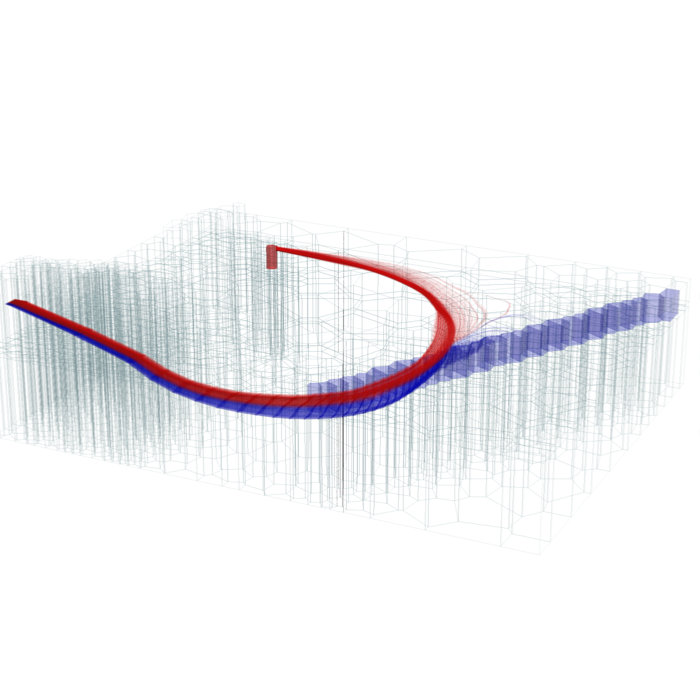

In [69]:
axes = pv.Axes(show_actor=False, actor_scale=2.0, line_width=5)
vtk = Vtk(model=gwf, binary=False, vertical_exageration=1, smooth=False)
vtk.add_model(gwf)
vtk.add_pathline_points(prt_pathlines)
gwf_mesh, prt_mesh = vtk.to_pyvista()

# rotate camera
gwf_mesh.rotate_z(110, point=axes.origin, inplace=True)
gwf_mesh.rotate_y(-10, point=axes.origin, inplace=True)
gwf_mesh.rotate_x(10, point=axes.origin, inplace=True)
prt_mesh.rotate_z(110, point=axes.origin, inplace=True)
prt_mesh.rotate_y(-10, point=axes.origin, inplace=True)
prt_mesh.rotate_x(10, point=axes.origin, inplace=True)

# extract grid features: top layer, well, stream
well_mesh = gwf_mesh.remove_cells(
    list(set(range(voronoi_grid.nnodes * 3)) - set(nodes["well"])), inplace=False
)
river_mesh = gwf_mesh.remove_cells(
    list(set(range(voronoi_grid.nnodes * 3)) - set(nodes["stream"])), inplace=False
)

# create plot
p = pv.Plotter(
    window_size=[700, 700],
    notebook=True,
)
p.enable_anti_aliasing()
p.add_mesh(
    gwf_mesh,
    opacity=0.1,
    style="wireframe",
)
p.add_mesh(well_mesh, color="red", opacity=0.4, show_edges=False)
p.add_mesh(river_mesh, color="blue", opacity=0.15, show_edges=False)
p.add_mesh(
    prt_mesh,
    opacity=0.04,
    scalars="destzone",
    cmap=["red", "blue"],
    point_size=4,
    line_width=3,
    render_points_as_spheres=True,
    render_lines_as_tubes=True,
    smooth_shading=True,
)
p.remove_scalar_bar("destzone")
p.camera.zoom(1.4)
p.show()
